## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
final_data = pd.read_csv('final_data.csv')

In [3]:
final_data.shape

(10754, 22)

In [4]:
final_data.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [5]:
# uniqeness
final_data.drop_duplicates(inplace=True)
final_data[final_data.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [6]:
# Completeness
final_data.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [7]:
# Accurecy types
final_data.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [8]:
award_counts = final_data.groupby('name')['award'].sum().sort_values(ascending=False)

top_10_names = award_counts.head(10)

name_with_highest_award = top_10_names.idxmax()
highest_award_count = top_10_names.max()

fig = px.bar(top_10_names, x=top_10_names.values, y=top_10_names.index, orientation='h', 
             labels={'x': 'Award Count', 'index': 'Name'}, title='Top 10 Names Based on Award Counts')

fig.add_shape(type="line", x0=0, x1=highest_award_count, y0=name_with_highest_award, 
              y1=name_with_highest_award, line=dict(color="Red", width=3), xref='x', yref='y')

fig.add_annotation(x=highest_award_count, y=name_with_highest_award, 
                   text=f'Highest Award Count: {highest_award_count}', 
                   showarrow=True, arrowhead=2, ax=20, ay=-30)

fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()

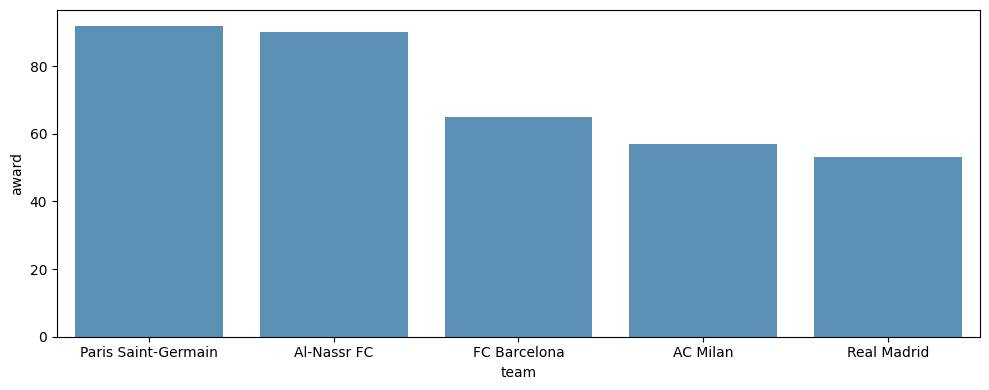

In [9]:
top_teams = final_data.nlargest(5, 'award')

plt.figure(figsize=(10, 4))
sns.barplot(data=top_teams, x='team', y='award', alpha=0.8)
plt.tight_layout()
plt.show()

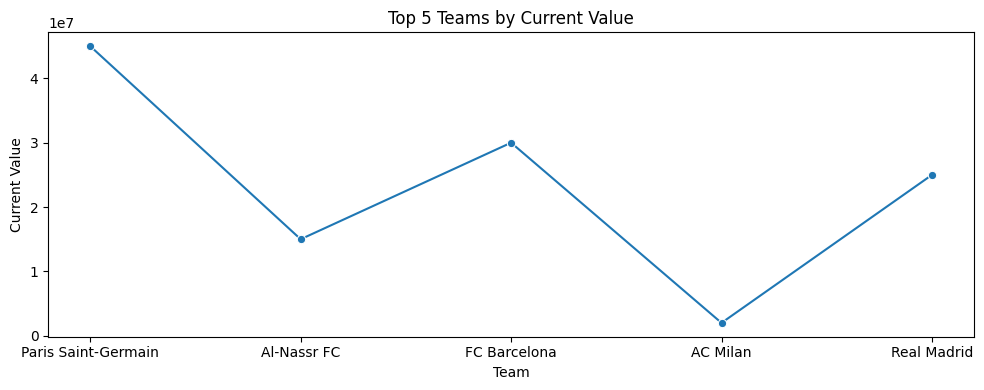

In [10]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=top_teams, x='team', y='current_value', marker='o')
plt.title('Top 5 Teams by Current Value')
plt.xlabel('Team')
plt.ylabel('Current Value')
plt.tight_layout()
plt.show()

In [11]:
# final_data['age'] = final_data['age'].astype(int)
# final_data['height'] = final_data['height'].astype(int)
# final_data['goals'] = final_data['goals'].astype(int)
# final_data['clean sheets'] = final_data['clean sheets'].astype(int)

In [12]:

numeric_features = ['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'current_value', 'highest_value', 'position_encoded', 'winger']


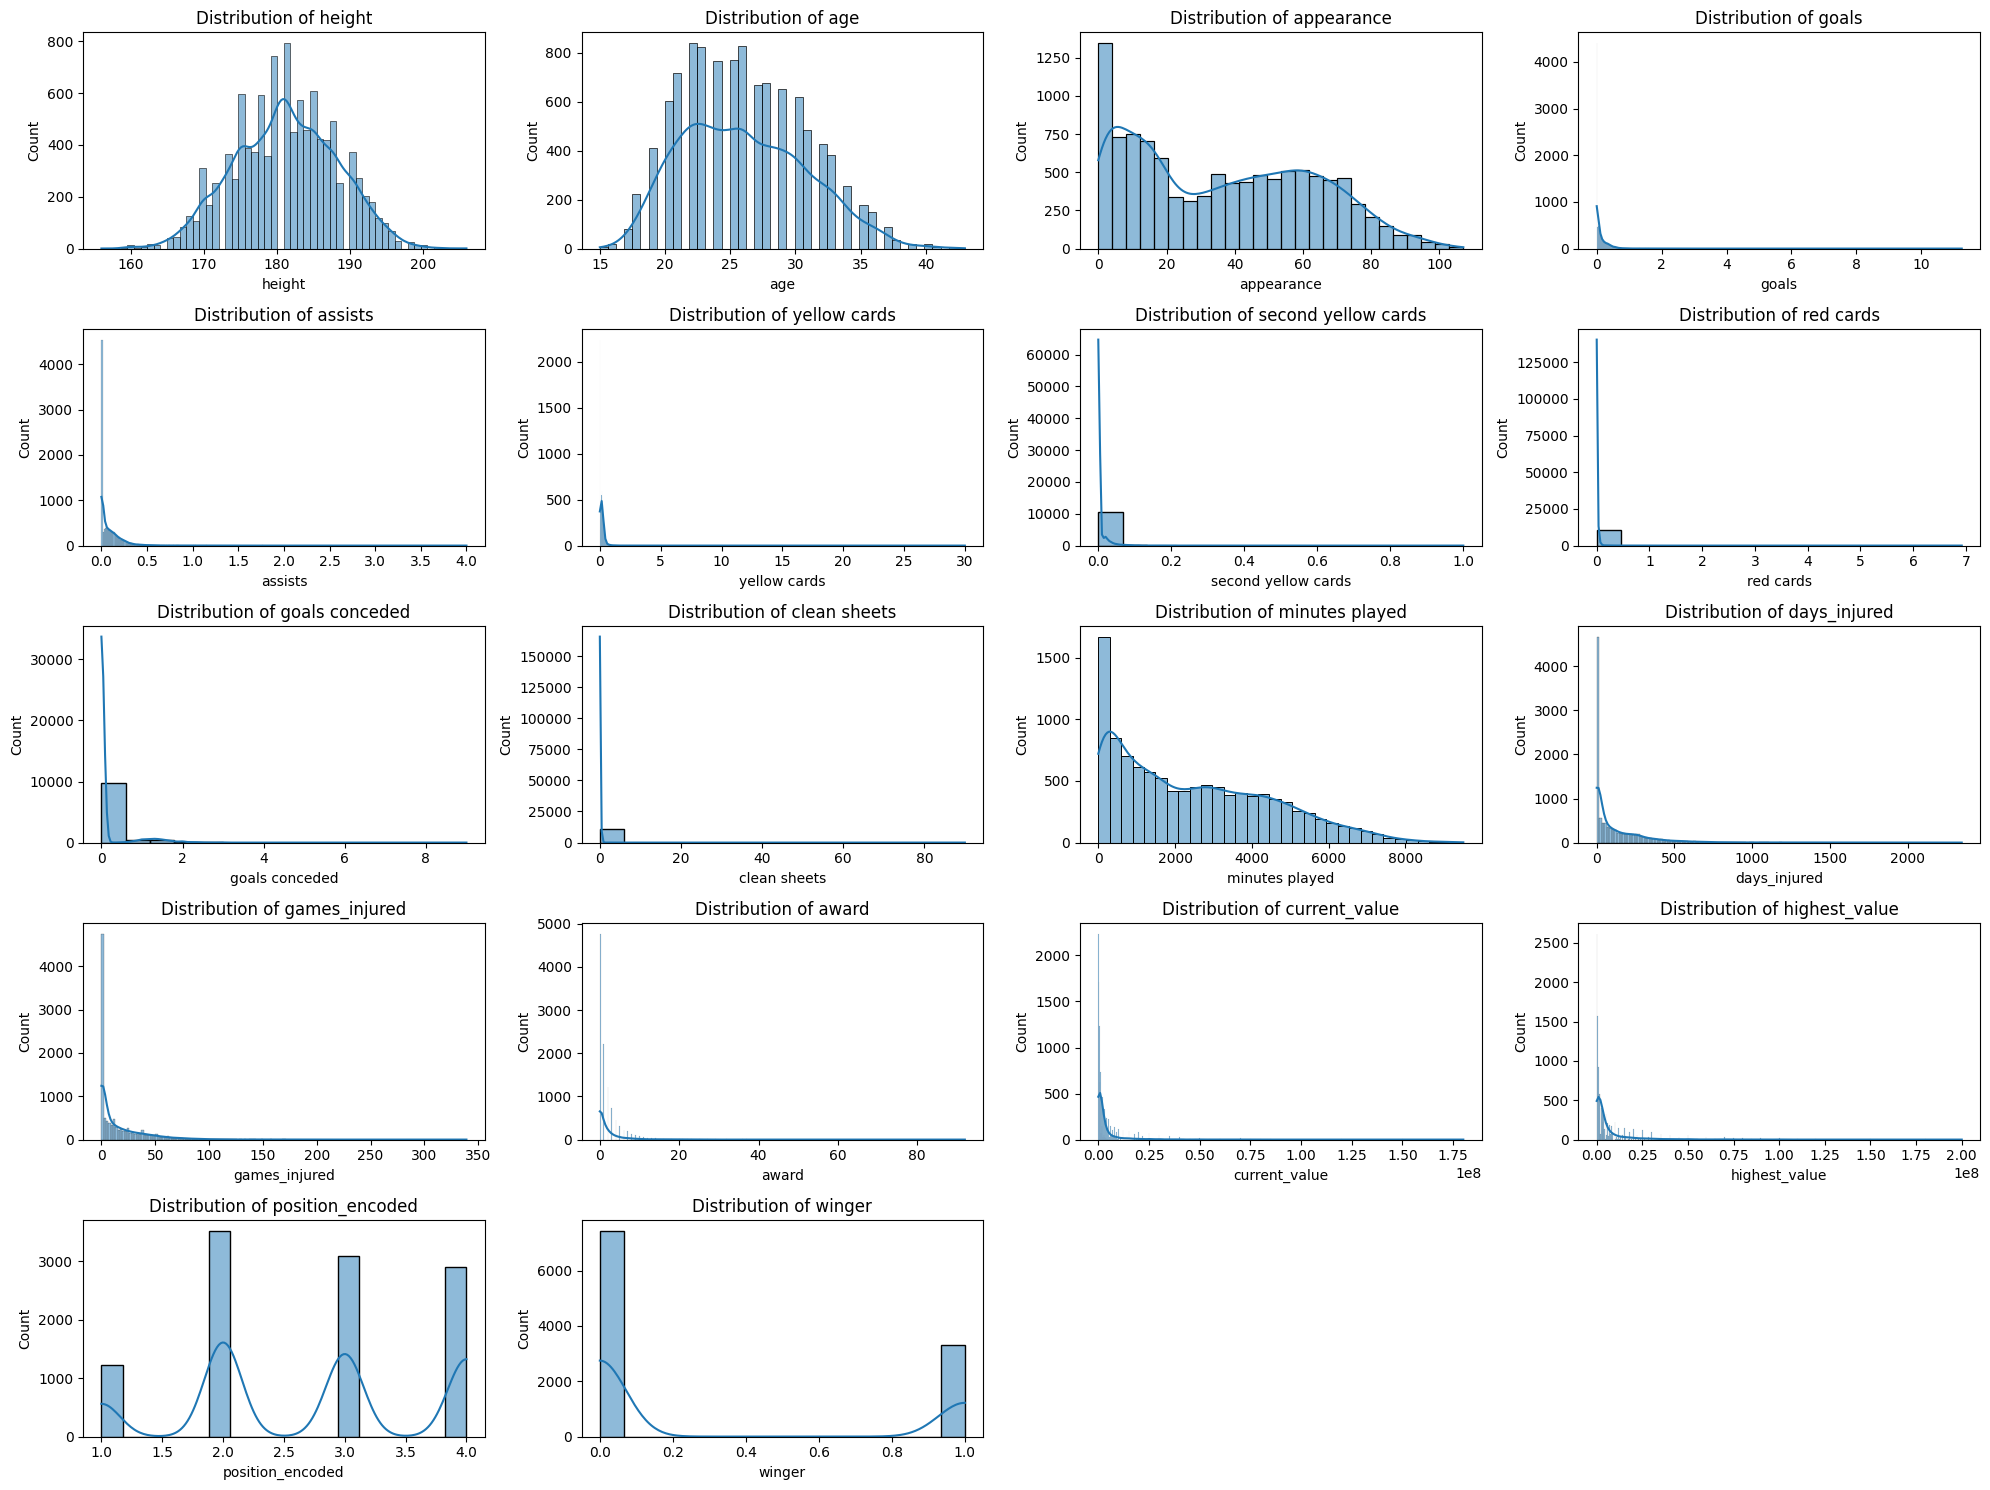

In [13]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 4, i+1)
    sns.histplot(final_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [14]:
# Accurecy - Outlier

# Convert categorical variables using On eHotEncoding
categorical_features = ['team', 'name', 'position']



In [15]:
for i in categorical_features:
    print (final_data[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
name
Paulinho              6
Vitinho               5
Guilherme             5
Fernando              4
João Pedro            4
                     ..
Everson               1
Matheus Mendes        1
Gabriel Delfim        1
Nathan Silva          1
Alexander Badolato    1
Name: count, Length: 10584, dtype: int64
position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Att

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [16]:
final_data.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [17]:
categorical_features

['team', 'name', 'position']

In [18]:
# one hot coding
final_data = pd.get_dummies(final_data, columns=categorical_features)

In [19]:
final_data.shape

(10754, 10993)

In [20]:
final_data.head(2)

,player,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,/david-de-gea/profil/spieler/59377,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,...,False,False,False,True,False,False,False,False,False,False
1,/jack-butland/profil/spieler/128899,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,...,False,False,False,True,False,False,False,False,False,False


#### 3. Feature selection

In [21]:
final_data.head(5)

,player,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,/david-de-gea/profil/spieler/59377,189.0,32.0,104,0.000000,0.000000,0.009585,0.0,0.0,1.217252,...,False,False,False,True,False,False,False,False,False,False
1,/jack-butland/profil/spieler/128899,196.0,30.0,15,0.000000,0.000000,0.069018,0.0,0.0,1.242331,...,False,False,False,True,False,False,False,False,False,False
2,/tom-heaton/profil/spieler/34130,188.0,37.0,4,0.000000,0.000000,0.000000,0.0,0.0,0.616438,...,False,False,False,True,False,False,False,False,False,False
3,/lisandro-martinez/profil/spieler/480762,175.0,25.0,82,0.028090,0.056180,0.224719,0.0,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False
4,/raphael-varane/profil/spieler/164770,191.0,30.0,63,0.017889,0.017889,0.053667,0.0,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False


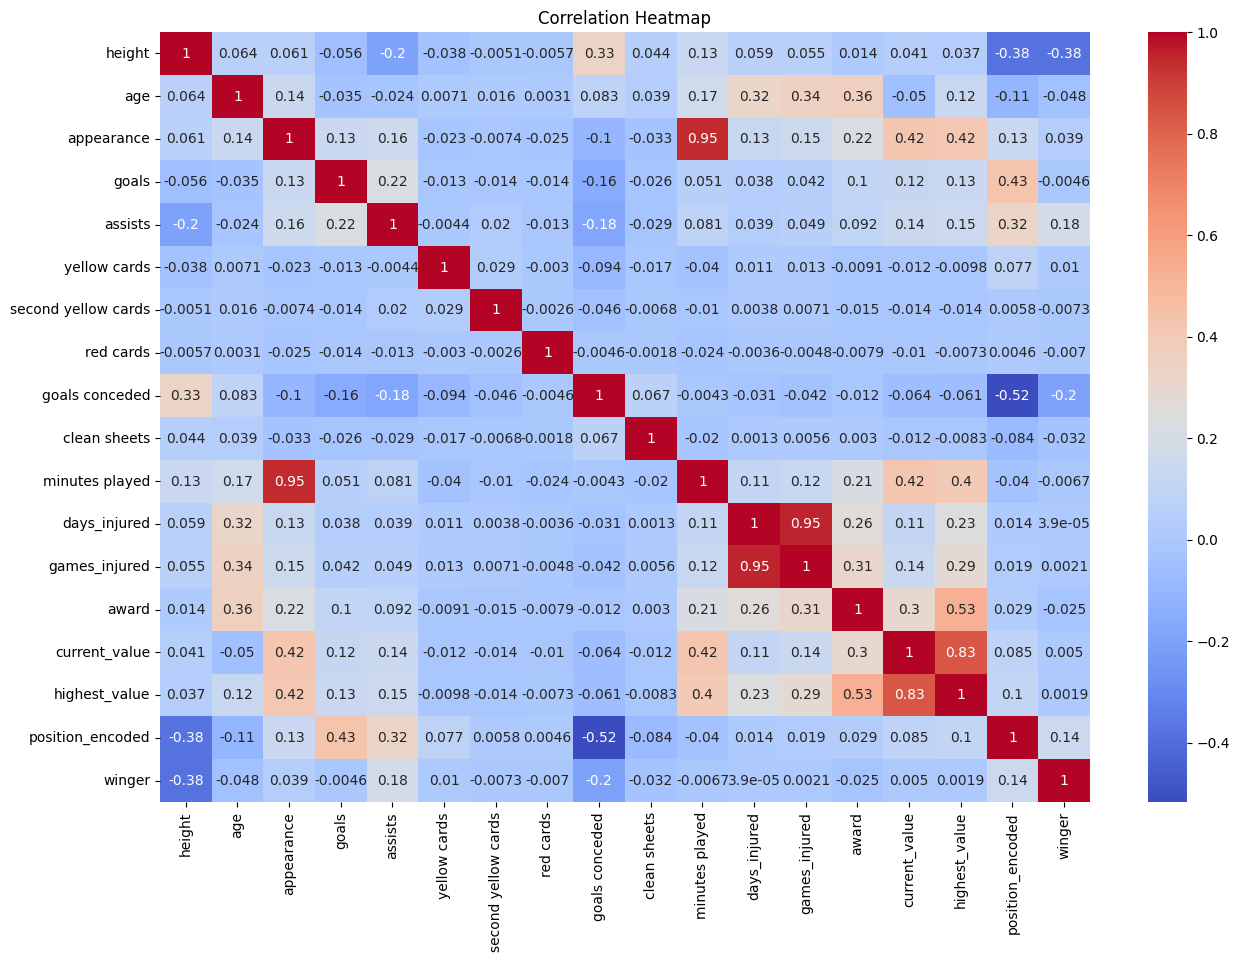

current_value          1.000000
highest_value          0.834553
minutes played         0.420542
appearance             0.419656
award                  0.300454
assists                0.137415
games_injured          0.135654
goals                  0.121574
days_injured           0.107686
position_encoded       0.085154
height                 0.040535
winger                 0.005034
red cards             -0.010171
clean sheets          -0.011684
yellow cards          -0.011766
second yellow cards   -0.013889
age                   -0.050156
goals conceded        -0.063529
Name: current_value, dtype: float64


In [22]:
correlation = final_data[numeric_features].corr()

# Display the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Get the correlation of each feature with the target variable
corr_with_target = correlation['current_value'].sort_values(ascending=False)
print(corr_with_target)

In [23]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
print("Selected Features:", selected_features)

# Select the top features for modeling
final_data = final_data[selected_features]
print(final_data.head())

Selected Features: Index(['appearance', 'minutes played', 'award', 'current_value',
       'highest_value'],
      dtype='object')
   appearance  minutes played  award  current_value  highest_value
0         104            9390     13       15000000       70000000
1          15            1304      1        1500000       22000000
2           4             292      4         600000        6000000
3          82            6408      9       50000000       50000000
4          63            5031     21       40000000       80000000


In [24]:
final_data = final_data[selected_features]
final_data.head()

,appearance,minutes played,award,current_value,highest_value
0,104,9390,13,15000000,70000000
1,15,1304,1,1500000,22000000
2,4,292,4,600000,6000000
3,82,6408,9,50000000,50000000
4,63,5031,21,40000000,80000000


#### 4. Prepare train and test data

In [25]:
# Prepare data
X = final_data.drop(columns=['current_value'])
y = final_data['current_value']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
X.shape

(10754, 4)

## Buliding the Model

In [27]:
model = LinearRegression()
ridge = Ridge()
lasso = Lasso()


In [28]:
param_grid = {
    'alpha': [95, 96, 97, 98, 99, 94, 1, 5]  # Regularization strength
}
grid_search = GridSearchCV(estimator=ridge ,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso ,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [29]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [30]:
# Fit the model on the training data
ridge.fit(X_train_scaled, y_train)


Ridge()

In [31]:
lasso.fit(X_train_scaled, y_train)

Lasso()

In [32]:
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [95, 96, 97, 98, 99, 94, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

In [33]:
grid_search_lasso.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [95, 96, 97, 98, 99, 94, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

## Test the Model

In [34]:
y_pred = model.predict(X_test_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)
# Best hyperparameter
print("Best parameters found: ", grid_search.best_params_)

# Best model
best_ridge = grid_search.best_estimator_

Best parameters found:  {'alpha': 1}


In [35]:
# Best hyperparameter
print("Best parameters found: ", grid_search_lasso.best_params_)

# Best model
best_ridge = grid_search_lasso.best_estimator_

Best parameters found:  {'alpha': 1}


In [36]:
y_pred_ridge_cv = best_ridge.predict(X_test_scaled)


## Interpretation of the Model

In [37]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.067133e+06
minutes played,1.971712e+06
award,-1.891462e+06
highest_value,8.139863e+06


In [38]:
print(model.intercept_) 

3622354.9924444957


In [39]:
coeff_df = pd.DataFrame(lasso.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.067114e+06
minutes played,1.971693e+06
award,-1.891460e+06
highest_value,8.139860e+06


In [40]:
coeff_df = pd.DataFrame(ridge.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.063434e+06
minutes played,1.968459e+06
award,-1.890426e+06
highest_value,8.138118e+06


In [41]:
coeff_df = pd.DataFrame(best_ridge.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.067114e+06
minutes played,1.971693e+06
award,-1.891460e+06
highest_value,8.139860e+06


## Evaluating the Model 

1. Mean Square Error

In [42]:
y_base = [y_train.mean()] * len(y_test)

In [43]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 90434700474058.52


In [44]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 21529110391273.445
Mean Squared Error for testing: 23838959700918.492


2. Mean Absolute Error

In [45]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 4482422.870661328


In [46]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 2095891.608066295
Mean Absolute Error for testing: 2148392.2005032385


3. Root Mean Squared Error

In [47]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 2117.1733208836085


In [48]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 4639947.240138992
Root Mean Squared Error for testing: 4882515.714354485


4. R Square

In [49]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.7335162692635426
R Square for testing: 0.7363958516354421


#### Predictions vs. Real Values

In [50]:
predictions = model.predict(X_test_scaled)
#predictions

In [51]:
Real_Values = np.array(y_test)
#Real_Values

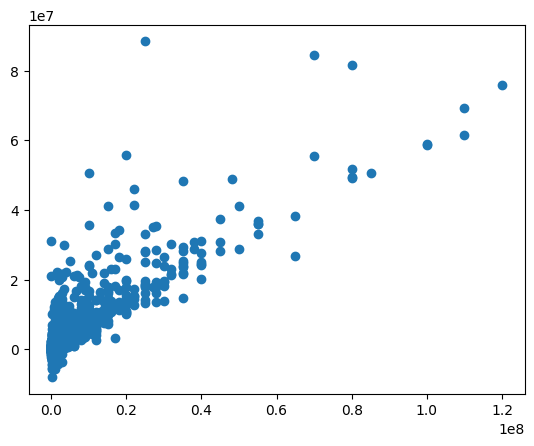

In [52]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

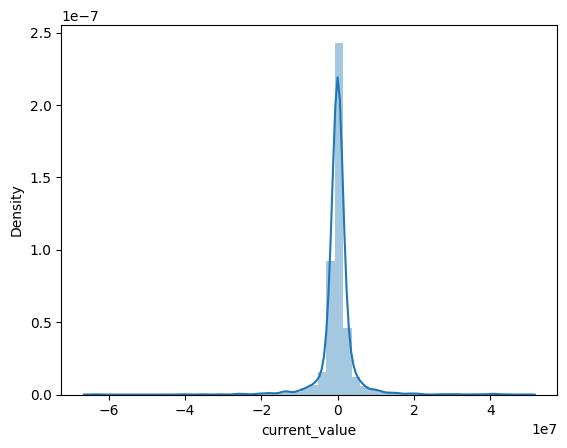

In [53]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution